In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_PROCESSED, RANDOM_STATE, CONTAMINATION_RATE

pd.set_option("display.float_format", "{:,.4f}".format)
print("✅ Imports OK")

✅ Imports OK


In [2]:
fm = pd.read_parquet(DATA_PROCESSED / "feature_matrix.parquet")
print(f"Loaded {len(fm):,} rows × {fm.shape[1]} columns")

Loaded 1,500,000 rows × 46 columns


In [3]:
# These are the ONLY features the anomaly models see.
# No proxy labels, no identifiers, no raw value (use log instead).
# Rule: behavioral and structural features only.

ANOMALY_FEATURES = [
    # Contract behavior
    "log_valor",
    "duracion_dias",
    "dias_firma_a_inicio",
    "flag_rush",
    "flag_q4",
    "flag_december",
    "flag_short_contract",
    "flag_long_contract",
    "is_direct",
    "is_modified",
    "is_cancelled",
    "flag_extended",
    "dias_adicionados",

    # Vendor behavior
    "vendor_total_contracts",
    "vendor_distinct_agencies",
    "vendor_direct_rate",
    "vendor_modified_rate",
    "vendor_tenure_days",
    "vendor_agency_diversity",
    "log_vendor_total_spend",

    # Agency concentration
    "agency_direct_rate",
    "agency_modified_rate",
    "agency_hhi",
    "agency_top_vendor_share",
    "flag_agency_concentrated",
]

X = fm[ANOMALY_FEATURES].copy()

# Final null check
assert X.isnull().sum().sum() == 0, "Nulls found in anomaly features"
print(f"Anomaly feature matrix: {X.shape}")
print(f"Features used: {len(ANOMALY_FEATURES)}")

Anomaly feature matrix: (1500000, 25)
Features used: 25


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=ANOMALY_FEATURES, index=X.index)

print("Features scaled with StandardScaler.")
print(f"Mean (should be ~0): {X_scaled.mean().mean():.4f}")
print(f"Std  (should be ~1): {X_scaled.std().mean():.4f}")

Features scaled with StandardScaler.
Mean (should be ~0): -0.0000
Std  (should be ~1): 1.0000


In [5]:
from sklearn.ensemble import IsolationForest

print("Training Isolation Forest...")
print(f"  Contamination rate: {CONTAMINATION_RATE}")
print(f"  Random state: {RANDOM_STATE}")

iso = IsolationForest(
    n_estimators=200,
    contamination=CONTAMINATION_RATE,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
iso.fit(X_scaled)

# Raw scores — more negative = more anomalous
iso_raw = iso.score_samples(X_scaled)

# Flip and normalize to [0,1] — higher = more anomalous
iso_score = -iso_raw
iso_score = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min())

fm["score_isoforest"] = iso_score

print(f"✅ Isolation Forest done.")
print(f"  Score range: {iso_score.min():.4f} → {iso_score.max():.4f}")
print(f"  Mean score:  {iso_score.mean():.4f}")
print(f"  Top 5% threshold: {np.percentile(iso_score, 95):.4f}")

Training Isolation Forest...
  Contamination rate: 0.05
  Random state: 42
✅ Isolation Forest done.
  Score range: 0.0000 → 1.0000
  Mean score:  0.1807
  Top 5% threshold: 0.5418


In [6]:
from pyod.models.hbos import HBOS

print("Training HBOS...")

hbos = HBOS(
    n_bins=50,
    contamination=CONTAMINATION_RATE,
)
hbos.fit(X_scaled)

hbos_raw = hbos.decision_scores_

# Normalize to [0,1]
hbos_score = (hbos_raw - hbos_raw.min()) / (hbos_raw.max() - hbos_raw.min())

fm["score_hbos"] = hbos_score

print(f"✅ HBOS done.")
print(f"  Score range: {hbos_score.min():.4f} → {hbos_score.max():.4f}")
print(f"  Mean score:  {hbos_score.mean():.4f}")
print(f"  Top 5% threshold: {np.percentile(hbos_score, 95):.4f}")

Training HBOS...
✅ HBOS done.
  Score range: 0.0000 → 1.0000
  Mean score:  0.1951
  Top 5% threshold: 0.5309


In [7]:
# Rank averaging reduces sensitivity to outliers in either model
# and produces a more stable combined score

iso_ranks = pd.Series(iso_score).rank(pct=True)
hbos_ranks = pd.Series(hbos_score).rank(pct=True)

process_anomaly_score = (iso_ranks + hbos_ranks) / 2

fm["process_anomaly_score"] = process_anomaly_score.values

print("Process anomaly score (rank average):")
print(f"  Min:    {process_anomaly_score.min():.4f}")
print(f"  Median: {process_anomaly_score.median():.4f}")
print(f"  Mean:   {process_anomaly_score.mean():.4f}")
print(f"  Max:    {process_anomaly_score.max():.4f}")

Process anomaly score (rank average):
  Min:    0.0029
  Median: 0.4860
  Mean:   0.5000
  Max:    1.0000


In [8]:
# Chi-square test: are high-scoring contracts more likely to match proxy label?
# This is your statistical validation — not accuracy, but association strength.

proxy = fm["proxy_strong"].values
top5_flag = (fm["process_anomaly_score"] >= np.percentile(process_anomaly_score, 95)).astype(int).values

contingency = pd.crosstab(
    pd.Series(top5_flag, name="Top 5% Risk"),
    pd.Series(proxy, name="Proxy Label")
)
print("Contingency Table (Top 5% flag vs Proxy Label):\n")
print(contingency.to_string())

chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

# Cramér's V — effect size
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

print(f"\nChi-square statistic: {chi2:,.2f}")
print(f"P-value:              {p_value:.2e}")
print(f"Cramér's V:           {cramers_v:.4f}")
print(f"\nInterpretation:")
print(f"  p < 0.05 → statistically significant association ✅" if p_value < 0.05 else "  p >= 0.05 → no significant association ⚠️")
print(f"  Cramér's V > 0.10 → meaningful effect size ✅" if cramers_v > 0.10 else "  Cramér's V <= 0.10 → weak effect size ⚠️")

Contingency Table (Top 5% flag vs Proxy Label):

Proxy Label        0       1
Top 5% Risk                 
0            1194653  230347
1              67901    7099

Chi-square statistic: 2,399.55
P-value:              0.00e+00
Cramér's V:           0.0400

Interpretation:
  p < 0.05 → statistically significant association ✅
  Cramér's V <= 0.10 → weak effect size ⚠️


Score correlation (IsoForest vs HBOS): 0.8875

Top 5% overlap:
  Isolation Forest flags: 75,000
  HBOS flags:             75,000
  Both flag:              44,564 (59.4% of ISO top 5%)
  Only ISO flags:         30,436
  Only HBOS flags:        30,436


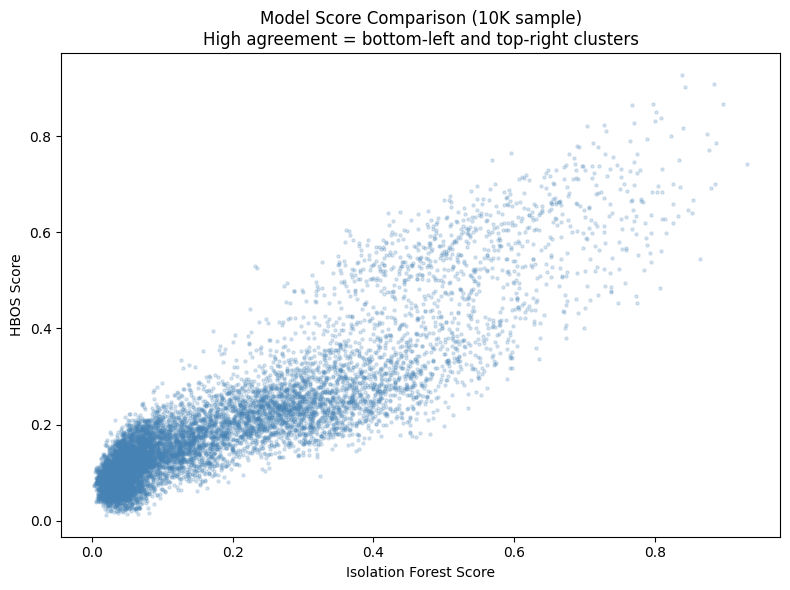

In [9]:
# How much do the two models agree?
# Where they disagree tells you about failure modes.

correlation = np.corrcoef(iso_score, hbos_score)[0, 1]
print(f"Score correlation (IsoForest vs HBOS): {correlation:.4f}")

# Overlap in top 5%
top5_iso = set(np.where(iso_score >= np.percentile(iso_score, 95))[0])
top5_hbos = set(np.where(hbos_score >= np.percentile(hbos_score, 95))[0])
overlap = len(top5_iso & top5_hbos)
print(f"\nTop 5% overlap:")
print(f"  Isolation Forest flags: {len(top5_iso):,}")
print(f"  HBOS flags:             {len(top5_hbos):,}")
print(f"  Both flag:              {overlap:,} ({overlap/len(top5_iso)*100:.1f}% of ISO top 5%)")
print(f"  Only ISO flags:         {len(top5_iso - top5_hbos):,}")
print(f"  Only HBOS flags:        {len(top5_hbos - top5_iso):,}")

# Scatter plot of scores
sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(fm), size=10000, replace=False)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(iso_score[sample_idx], hbos_score[sample_idx],
           alpha=0.2, s=5, color="steelblue")
ax.set_xlabel("Isolation Forest Score")
ax.set_ylabel("HBOS Score")
ax.set_title("Model Score Comparison (10K sample)\nHigh agreement = bottom-left and top-right clusters")
plt.tight_layout()
plt.savefig("../outputs/charts/04_model_comparison.png", dpi=150)
plt.show()

In [10]:
# Manual inspection of top 50 highest scoring contracts
# This is qualitative validation — do they look suspicious?

top50 = fm.nlargest(50, "process_anomaly_score")[
    ["id_contrato", "codigo_entidad", "codigo_proveedor",
     "valor_del_contrato", "is_direct", "is_modified",
     "flag_rush", "vendor_total_contracts",
     "agency_hhi", "process_anomaly_score", "proxy_strong"]
]

print("Top 50 highest-risk contracts:\n")
print(top50.to_string(index=False))

Top 50 highest-risk contracts:

       id_contrato codigo_entidad codigo_proveedor  valor_del_contrato  is_direct  is_modified  flag_rush  vendor_total_contracts  agency_hhi  process_anomaly_score  proxy_strong
CO1.PCCNTR.1060013      700834104        700345028        480077884683          0            1          0                     123      0.7826                 1.0000             0
CO1.PCCNTR.3076326      711149658        700918212         40920011040          1            1          0                      25      0.9600                 1.0000             1
CO1.PCCNTR.3107706      703693010        703961854              995000          0            0          1                     538      0.9885                 1.0000             0
CO1.PCCNTR.3107706      703693010        703961854              995000          0            0          1                     538      0.9885                 1.0000             0
CO1.PCCNTR.1243122      702309964        702114315           223000000   

In [11]:
output_path = DATA_PROCESSED / "anomaly_scores.parquet"
fm.to_parquet(output_path, index=False, compression="snappy")

print("=" * 55)
print("✅ ANOMALY DETECTION COMPLETE")
print("=" * 55)
print(f"  Rows scored:           {len(fm):,}")
print(f"  IsoForest mean score:  {fm['score_isoforest'].mean():.4f}")
print(f"  HBOS mean score:       {fm['score_hbos'].mean():.4f}")
print(f"  Process anomaly mean:  {fm['process_anomaly_score'].mean():.4f}")
print(f"  Chi-square p-value:    {p_value:.2e}")
print(f"  Cramér's V:            {cramers_v:.4f}")
print(f"  Saved to:              {output_path}")
print("=" * 55)

✅ ANOMALY DETECTION COMPLETE
  Rows scored:           1,500,000
  IsoForest mean score:  0.1807
  HBOS mean score:       0.1951
  Process anomaly mean:  0.5000
  Chi-square p-value:    0.00e+00
  Cramér's V:            0.0400
  Saved to:              C:\Users\HP\Collections\VsCode Projects\AuditLens\data\processed\anomaly_scores.parquet
